In [1]:
# Dependencies
import numpy as np
import pandas as pd

In [2]:
from sqlalchemy import create_engine
from hold import connection_string

In [3]:
engine = create_engine(f'{connection_string}', encoding='iso-8859-1', connect_args={'connect_timeout': 10})

In [4]:
gtdDF = pd.read_sql_table('global_terrorism', con= engine)

In [5]:
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,claimmode_txt,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,None,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,None,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,None,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0


In [6]:
WeaponTypesDF = gtdDF[['index1','weaptype1_txt']]
WeaponTypesDF.head()

,index1,weaptype1_txt
0,1.0,Firearms
1,2.0,Firearms
2,3.0,Firearms
3,4.0,Explosives/Bombs/Dynamite
4,5.0,Firearms


In [7]:
filterlist = ['Unknown','Other']
WeaponTypesFilterDF = WeaponTypesDF[~WeaponTypesDF['weaptype1_txt'].isin(filterlist)]
WeaponTypesFilterDF.head()

,index1,weaptype1_txt
0,1.0,Firearms
1,2.0,Firearms
2,3.0,Firearms
3,4.0,Explosives/Bombs/Dynamite
4,5.0,Firearms


In [8]:
WeaponTypes2DF = pd.get_dummies(WeaponTypesFilterDF)
WeaponTypes2DF.head()

,index1,weaptype1_txt_Biological,weaptype1_txt_Chemical,weaptype1_txt_Explosives/Bombs/Dynamite,weaptype1_txt_Fake Weapons,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Melee,weaptype1_txt_Radiological,weaptype1_txt_Sabotage Equipment,"weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)"
0,1.0,0,0,0,0,1,0,0,0,0,0
1,2.0,0,0,0,0,1,0,0,0,0,0
2,3.0,0,0,0,0,1,0,0,0,0,0
3,4.0,0,0,1,0,0,0,0,0,0,0
4,5.0,0,0,0,0,1,0,0,0,0,0


In [9]:
WeaponTypesMergeDF = result = pd.merge(WeaponTypes2DF,WeaponTypesFilterDF[['index1','weaptype1_txt']],on='index1')
WeaponTypesMergeDF.columns = WeaponTypesMergeDF.columns.str.replace('weaptype1_txt_', '')
WeaponTypesMergeDF.head()

,index1,Biological,Chemical,Explosives/Bombs/Dynamite,Fake Weapons,Firearms,Incendiary,Melee,Radiological,Sabotage Equipment,"Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)",weaptype1_txt
0,1.0,0,0,0,0,1,0,0,0,0,0,Firearms
1,2.0,0,0,0,0,1,0,0,0,0,0,Firearms
2,3.0,0,0,0,0,1,0,0,0,0,0,Firearms
3,4.0,0,0,1,0,0,0,0,0,0,0,Explosives/Bombs/Dynamite
4,5.0,0,0,0,0,1,0,0,0,0,0,Firearms


In [10]:
# Assign X (data) and y (target)
X = WeaponTypesMergeDF.drop(["index1","weaptype1_txt",], axis=1)
y = WeaponTypesMergeDF["weaptype1_txt"]
feature_names = X.columns
print(X.shape, y.shape)

(87395, 10) (87395,)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, stratify=y)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
from keras.models import Sequential
from keras.layers import Dense

# Create model and add layers
model = Sequential()
# input dimensions should be X.shape
model.add(Dense(units=128, activation='relu', input_dim=10))
model.add(Dense(units=128, activation='relu'))
# Below units should be the value of X.shape
model.add(Dense(units=10, activation='softmax'))

In [13]:
# Compile and fit the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=20,
    shuffle=True,
    verbose=2
)

Epoch 1/20
 - 6s - loss: 0.0436 - acc: 0.9976
Epoch 2/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 3/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 4/20
 - 6s - loss: 0.0229 - acc: 0.9986
Epoch 5/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 6/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 7/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 8/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 9/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 10/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 11/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 12/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 13/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 14/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 15/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 16/20
 - 4s - loss: 0.0229 - acc: 0.9986
Epoch 17/20
 - 5s - loss: 0.0229 - acc: 0.9986
Epoch 18/20
 - 6s - loss: 0.0229 - acc: 0.9986
Epoch 19/20
 - 6s - loss: 0.0229 - acc: 0.9986
Epoch 20/20
 - 6s - loss: 0.0229 - acc: 0.9986


In [14]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.023606645443864073, Accuracy: 0.9985354020778983


In [15]:
encoded_predictions = model.predict_classes(X_test_scaled[:10])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)

C:\Users\kruiz\Anaconda3\envs\PythonData\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:20])}")

Predicted classes: ['Firearms' 'Explosives/Bombs/Dynamite' 'Explosives/Bombs/Dynamite'
 'Firearms' 'Explosives/Bombs/Dynamite' 'Firearms' 'Firearms' 'Melee'
 'Explosives/Bombs/Dynamite' 'Explosives/Bombs/Dynamite']
Actual Labels: ['Firearms', 'Explosives/Bombs/Dynamite', 'Explosives/Bombs/Dynamite', 'Firearms', 'Explosives/Bombs/Dynamite', 'Firearms', 'Firearms', 'Melee', 'Explosives/Bombs/Dynamite', 'Explosives/Bombs/Dynamite', 'Explosives/Bombs/Dynamite', 'Explosives/Bombs/Dynamite', 'Firearms', 'Explosives/Bombs/Dynamite', 'Firearms', 'Explosives/Bombs/Dynamite', 'Explosives/Bombs/Dynamite', 'Firearms', 'Firearms', 'Explosives/Bombs/Dynamite']


In [17]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
sorted(zip(model.feature_importances_, feature_names), reverse=True)

[(0.41780832, 'Firearms'),
 (0.28952432, 'Explosives/Bombs/Dynamite'),
 (0.1782471, 'Incendiary'),
 (0.08316136, 'Melee'),
 (0.012355311, 'Chemical'),
 (0.0070374007,
  'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'),
 (0.0069042887, 'Sabotage Equipment'),
 (0.0024488727, 'Biological'),
 (0.00125649, 'Radiological'),
 (0.00125649, 'Fake Weapons')]

In [19]:
DLWeapTypeAttacksDF = pd.DataFrame(sorted(zip(model.feature_importances_, feature_names), reverse=True), 
                               columns = ['Probability', 'Weapon Type'])
DLWeapTypeAttacksDF

,Probability,Weapon Type
0,0.417808,Firearms
1,0.289524,Explosives/Bombs/Dynamite
2,0.178247,Incendiary
3,0.083161,Melee
4,0.012355,Chemical
5,0.007037,Vehicle (not to include vehicle-borne explosiv...
6,0.006904,Sabotage Equipment
7,0.002449,Biological
8,0.001256,Radiological
9,0.001256,Fake Weapons


In [20]:
pies = DLWeapTypeAttacksDF['Weapon Type'].head(6)
pie_slices = DLWeapTypeAttacksDF['Probability'].head(6)
colors = ["lightskyblue","orange","pink","yellowgreen","lightcoral","silver","yellow",
          "lightgreen","wheat","khaki"]
explode = (0.1,0,0,0,0,0)

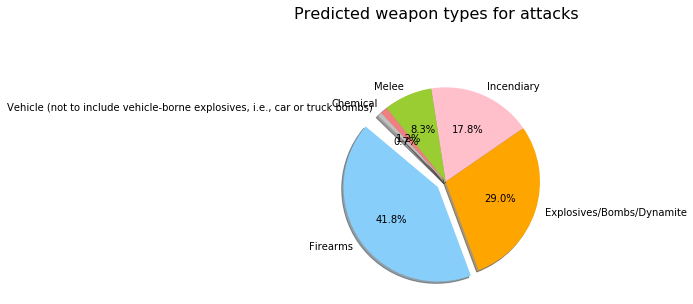

In [21]:
# Tell matplotlib to create a pie chart based upon the above data
pyplot.pie(pie_slices, explode=explode, labels=pies, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=140)
# Create axes which are equal so we have a perfect circle
pyplot.axis("equal")
# Save an image of our chart and print the final product to the screen

pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML20_WeaponType_Attacks_Pie_DL")
pyplot.suptitle('Predicted weapon types for attacks', size=16, y=1.12) 
pyplot.show()

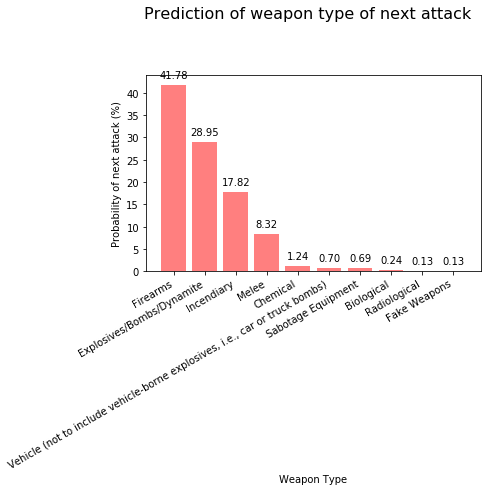

In [22]:
y_axis = DLWeapTypeAttacksDF['Probability']*100
x_axis = DLWeapTypeAttacksDF['Weapon Type']
fig, ax = pyplot.subplots()
# plot
ax.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()

# Labels for x and y axes
pyplot.xlabel("Weapon Type")
pyplot.ylabel("Probability of next attack (%)")

# Show the values of each probability on plot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

# Save an image of our chart and print the final product to the screen
pyplot.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML20_WeaponType_Attacks_Bar_DL")
# Title for the chart
pyplot.suptitle('Prediction of weapon type of next attack', size=16, y=1.12) 
pyplot.show()